## Load the images

In [1]:
import os

input_dir = "../images"
target_dir = "../images"
num_classes = 2
batch_size = 4

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 40
../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p107.jpg | ../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p107_annoted.png
../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p124.jpg | ../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p124_annoted.png
../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p140.jpg | ../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p140_annoted.png
../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p151.jpg | ../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p151_annoted.png
../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p163.jpg | ../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p163_annoted.png
../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p183.jpg | ../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p183_annoted.png
../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p195.jpg | ../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p195_annoted.png
../../Data/Images_set\3DUS_L_probe1_conf1_ds1.dcm_p213.jpg | ../../Data/Images_set

## Vizualise the dataset

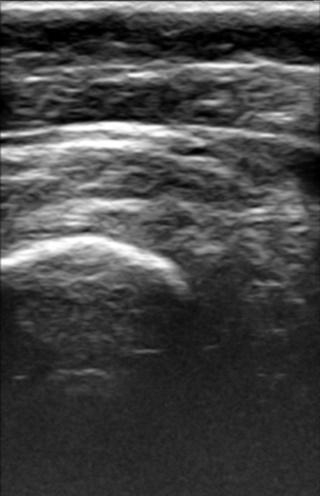

(496, 320, 3)


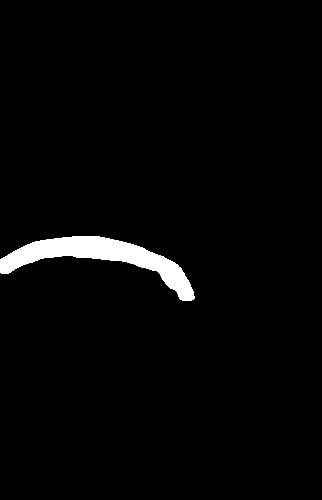

In [2]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Get the image shape
import cv2
im = cv2.imread(input_img_paths[9])
img_size = im.shape
print(img_size)

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Prepare Sequence class to load & vectorize batches of data

In [3]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

## Load the trained models

In [4]:
from models.vgg16 import get_model

vgg16 = get_model(input_shape=img_size, num_classes=num_classes)
vgg16 = vgg16.load_weights('trained-models/synovial-bone/TRANSFER_LEARNING_VGG16.hdf5')

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
vgg16.summary()

KeyError: 'Unable to open object (bad heap free list)'

## Try to recover the corrupted hdf5 files

In [ ]:
import h5py as h5

def RecoverFile( f1, f2 ):
    """  recover read-open HDF5 file f1 to write-open HDF5 file f2  """
    names = []
    f1.visit(names.append)
    for n in names:
        try:
            f2.create_dataset( n, data=f1[n][()] )
        except:
            pass


file_broken = 'trained-models/synovial-bone/TRANSFER_LEARNING_VGG19.hdf5'
file_recover = 'trained-models/synovial-bone/TRANSFER_LEARNING_VGG19_Repair.hdf5'
with h5.File( file_broken, 'r' ) as fb:
    with h5.File( file_recover, 'w' ) as fr:
        for key in fb.keys():
            try:
                fr.create_dataset( key, data=fb[key][()] )
            except:
                try:
                    fr.create_group(key)
                    RecoverFile( fb[key], fr[key] )
                except:
                    fr.__delitem__(key)

In [ ]:
import h5py
filename = 'trained-models/synovial-bone/TRANSFER_LEARNING_VGG19.hdf5'

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key])) 

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])

    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array

Keys: <KeysViewHDF5 ['model_weights', 'optimizer_weights']>
<class 'h5py._hl.group.Group'>


RuntimeError: Unable to get group info (bad symbol table node signature)

## Set aside a validation split

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 4
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
# vgg16.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
# vgg16.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
4/4 [==============================] - 21s 731ms/step - loss: nan - val_loss: nan
Epoch 2/15
4/4 [==============================] - 1s 371ms/step - loss: nan - val_loss: nan
Epoch 3/15
4/4 [==============================] - 1s 345ms/step - loss: nan - val_loss: nan
Epoch 4/15
4/4 [==============================] - 1s 332ms/step - loss: nan - val_loss: nan
Epoch 5/15
4/4 [==============================] - 1s 332ms/step - loss: nan - val_loss: nan
Epoch 6/15
4/4 [==============================] - 1s 330ms/step - loss: nan - val_loss: nan
Epoch 7/15
4/4 [==============================] - 1s 335ms/step - loss: nan - val_loss: nan
Epoch 8/15
4/4 [==============================] - 1s 348ms/step - loss: nan - val_loss: nan
Epoch 9/15
4/4 [==============================] - 1s 346ms/step - loss: nan - val_loss: nan
Epoch 10/15
4/4 [==============================] - 1s 343ms/step - loss: nan - val_loss: nan
Epoch 11/15
4/4 [==============================] - 1s 361ms/step - loss: nan -

## Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = vgg16.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

IndexError: list index out of range